In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from pathlib import Path
import seaborn as sns
import plotly.express as px
import functions as funcs
import pyemma as pm

import matplotlib as mpl

In [2]:
data_dir = Path('/Volumes/REA/Data/fast_folders/')


In [3]:
if Path('timescales.h5').exists():
    ts = pd.read_hdf('timescales.h5', key='timescales')
else:
    all_ts = []
    for prot, name in zip(funcs.PROTEIN_DIRS, funcs.PROTEIN_LABELS):
        protein_dir = data_dir.joinpath(prot)
        if protein_dir.exists():
            results_paths = list(protein_dir.rglob('*.h5'))
            if len(results_paths) > 0: 
                ts = funcs.get_results_df(results_paths, results='timescales')
                ts['protein'] = name
                all_ts.append(ts)
    ts = pd.concat(all_ts)
    ts.to_hdf('timescales.h5', key='timescales')

In [4]:
timescale_num = 2
use_log = True # percentage change in timescale as gradient
denom='delta_x'    

df_t = funcs.timescale_gradient(ts.loc[ts.num_its==2, :],x='lag',  log=True, denom=denom)
df_t = df_t.groupby(['protein', 'hp_index', 'lag'], as_index=False).median()
df_t.head()

,protein,hp_index,lag,value,iteration,delta_t,delta_x,grad_t
0,BBA,0.0,20.0,6.935262,50.5,0.414812,10.0,0.041481
1,BBA,0.0,30.0,7.148110,50.5,0.240055,10.0,0.024006
2,BBA,0.0,40.0,7.314059,50.5,0.164682,10.0,0.016468
3,BBA,0.0,50.0,7.436424,50.5,0.119029,10.0,0.011903
4,BBA,0.0,60.0,7.531314,50.5,0.090516,10.0,0.009052


In [5]:
grad_t_cutoff = np.log(1.01)

df_t.sort_values(by=['protein', 'hp_index', 'lag'], inplace=True)
ix = (df_t['grad_t'] < grad_t_cutoff) & (df_t['grad_t'] > 0)

chosen_lags = df_t.loc[ix,:].groupby(['protein', 'hp_index'], as_index=False).first()
chosen_lags = chosen_lags.groupby('protein', as_index=False).min()
chosen_lags


,protein,hp_index,lag,value,iteration,delta_t,delta_x,grad_t
0,BBA,0.0,40.0,6.915155,50.5,0.070440,10.0,0.007044
1,BBL,0.0,30.0,3.624249,50.5,0.009801,10.0,0.000980
2,Chignolin,0.0,20.0,4.719985,50.5,0.019848,10.0,0.001985
3,Homeodomain,1.0,20.0,5.625146,50.5,0.000394,10.0,0.000039
4,Protein-B,0.0,40.0,5.483887,50.5,0.006121,10.0,0.000612
5,Trp-cage,0.0,20.0,6.203824,50.5,0.001330,10.0,0.000133
6,Villin,0.0,30.0,5.097114,50.5,0.047781,10.0,0.004778
7,WW-domain,0.0,40.0,8.220099,50.5,0.066269,10.0,0.006627


In [6]:
chosen_lags.to_hdf('chosen_lag_times.h5', 'chosen_lags')

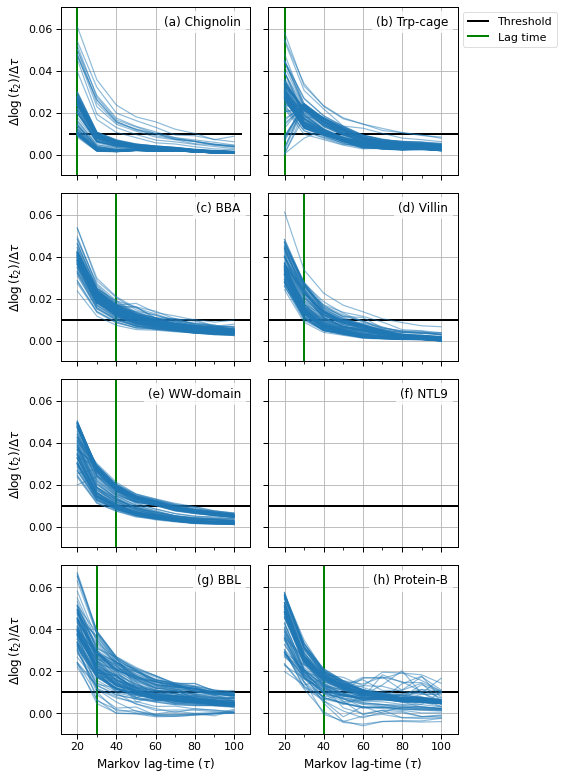

In [7]:
with sns.plotting_context('paper', font_scale=1.25):
    n_rows, n_cols = 4, 2
    sharey=True
    use_log = True # percentage change in timescale as gradient
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(8, 11), sharex=True, sharey=sharey)

    if use_log: 
        ylabel_top = r'$\Delta \log{{(t_{{{0}}})}}$'
    else:
        ylabel_top = r'$\Delta t_{{{0}}}$'
    if denom=='one':
        ylabel_bot = ''
    elif denom=='lag':
        ylabel_bot = r'/$\tau$'
    elif denom=='delta_x':
        ylabel_bot = r'/$\Delta \tau$'
        
    ylabel = ylabel_top+ylabel_bot
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]

            prot_ix = i*n_cols + j
            label = funcs.PROTEIN_LABELS[prot_ix]
            tmp = df_t.loc[df_t.protein==label, :]
            
            if sharey:
                if j == 0:
                    ax.set_ylabel(ylabel.format(timescale_num))
            else:
                ax.set_ylabel(ylabel.format(timescale_num))

            if i == n_rows - 1:
                ax.set_xlabel(r'Markov lag-time ($\tau$)')
                
            ax = sns.lineplot(data=tmp, units='hp_index', x='lag', y='grad_t', estimator=None, alpha=0.5, ax=ax)
            

            
            ax.annotate(text=f'({funcs.LETTERS[prot_ix]}) {label}', xy=(0.95, 0.95), 
                        xycoords='axes fraction', ha='right', va='top', 
                       bbox={'facecolor': 'w', 'alpha':0.8, 'edgecolor': 'w'})
    
    
    for i in range(n_rows):
        for j in range(n_cols):
            ax = axes[i, j]   
            prot_ix = i*n_cols + j
            label = funcs.PROTEIN_LABELS[prot_ix]
            
            xlim = ax.get_xlim()
            ax.hlines(grad_t_cutoff, *xlim, color='k', label='Threshold', lw=2)
            ax.set_xlim()
            
            if sharey:
                ylim = axes[0, 0].get_ylim()
            else:
                ylim = ax.get_ylim()
            
            chosen_lag = chosen_lags.loc[chosen_lags.protein==label, 'lag']
            
            ax.vlines(chosen_lag, *ylim, color='g', label='Lag time', lw=2)
            ax.set_ylim(ylim)
            if (i == 0) & (j == n_cols - 1):
                ax.legend(bbox_to_anchor=(1, 1), loc='upper left')
            
            ax.xaxis.set_major_locator(mpl.ticker.MultipleLocator(20))
            ax.xaxis.set_minor_locator(mpl.ticker.MultipleLocator(10))
            ax.grid()
    
    plt.tight_layout()
    plt.savefig(funcs.FIG_DIR.joinpath(f't_{timescale_num}_gradient_sharey_{sharey}_log_{use_log}_denom_{denom}.pdf'), bbox_inches='tight')